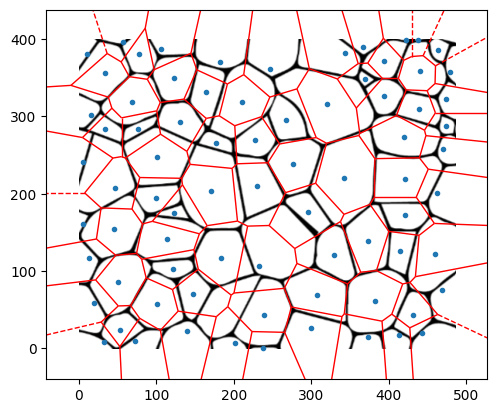

In [1]:
# File path: canny_voronoi.py

import cv2
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

# Load and preprocess the image
image_path = "micro2.png"  # Replace with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(image, 10, 20)  # Canny edge detection

# Find contours and centroids
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
centroids = [cv2.moments(cnt) for cnt in contours]
points = np.array([[int(c["m10"] / (c["m00"] + 1e-5)), int(c["m01"] / (c["m00"] + 1e-5))]
                   for c in centroids if c["m00"] > 0])

# Generate Voronoi diagram
vor = Voronoi(points)
plt.imshow(image, cmap='gray')
voronoi_plot_2d(vor, ax=plt.gca(), show_vertices=False, line_colors='red')
plt.show()


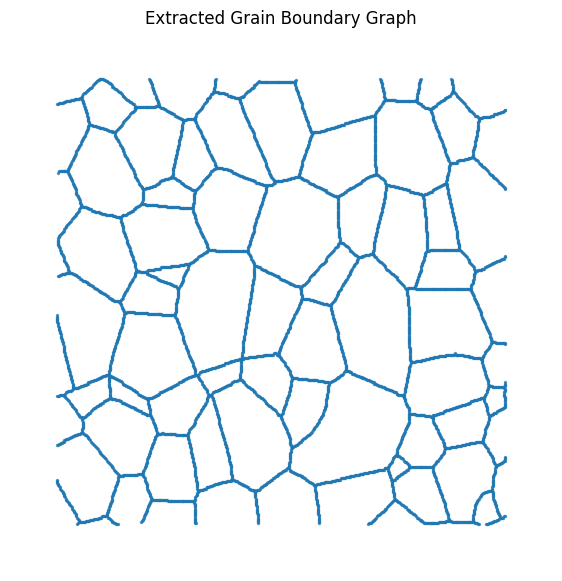

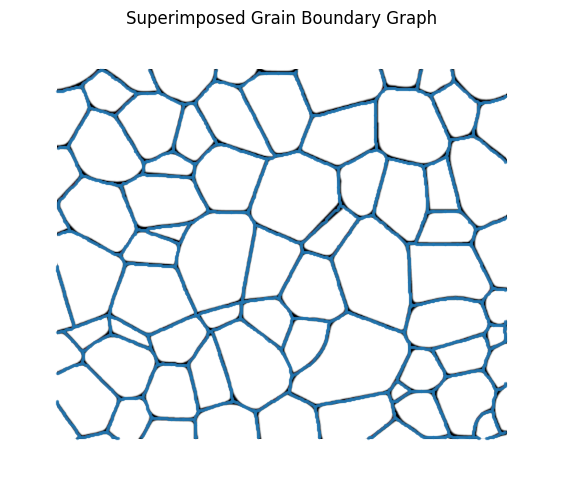

Estimated Percolation Threshold: 1.00


In [2]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.filters import threshold_otsu
from scipy.spatial import KDTree

# Step 1: Load and preprocess image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, threshold_otsu(img), 255, cv2.THRESH_BINARY_INV)
    return img, binary

# Step 2: Skeletonization
def extract_skeleton(binary_image):
    return skeletonize(binary_image // 255)  # Convert to binary before skeletonizing

# Step 3: Convert skeleton to graph
def skeleton_to_graph(skeleton):
    G = nx.Graph()
    rows, cols = np.where(skeleton)
    pixels = list(zip(rows, cols))
    
    # Create a spatial KDTree for efficient nearest neighbor lookup
    tree = KDTree(pixels)
    
    for pixel in pixels:
        x, y = pixel
        G.add_node((x, y))  # Each pixel is a node
        # Connect neighbors within a small radius (Euclidean distance)
        neighbors = tree.query_ball_point(pixel, 1.5)
        for n in neighbors:
            neighbor_pixel = pixels[n]
            if neighbor_pixel != pixel:
                G.add_edge(pixel, neighbor_pixel)
    
    return G

# Step 4: Find percolation threshold (largest connected component)
def percolation_analysis(G):
    largest_cc = max(nx.connected_components(G), key=len)  # Find largest connected cluster
    percolation_threshold = len(largest_cc) / len(G.nodes)
    return percolation_threshold, largest_cc

# Step 5: Plot the extracted graph separately
def plot_extracted_graph(G):
    plt.figure(figsize=(7, 7))
    plt.title("Extracted Grain Boundary Graph")
    pos = {node: (node[1], -node[0]) for node in G.nodes}  # Flip y-axis for better view
    nx.draw(G, pos, node_size=2, edge_color='gray', alpha=0.7, with_labels=False)
    plt.axis("off")
    plt.show()

# Step 6: Superimpose graph on the original image
def plot_graph_on_image(original_img, G):
    plt.figure(figsize=(7, 7))
    plt.imshow(original_img, cmap='gray')  # Show original image
    
    # Draw graph nodes (blue) and edges (red)
    pos = {node: (node[1], node[0]) for node in G.nodes}  # Convert (x, y) to (col, row)
    nx.draw(G, pos, node_size=2, edge_color='r', alpha=0.5, with_labels=False)
    
    plt.title("Superimposed Grain Boundary Graph")
    plt.axis("off")
    plt.show()

# Main Execution
image_path = "micro2.png"  # Replace with your image path
original_img, binary_img = preprocess_image(image_path)
skeleton = extract_skeleton(binary_img)
G = skeleton_to_graph(skeleton)

# Percolation Threshold Calculation
threshold, largest_cluster = percolation_analysis(G)

# Plot separate results
plot_extracted_graph(G)      # Show only the graph
plot_graph_on_image(original_img, G)  # Show graph overlaid on the microstructure

print(f"Estimated Percolation Threshold: {threshold:.2f}")


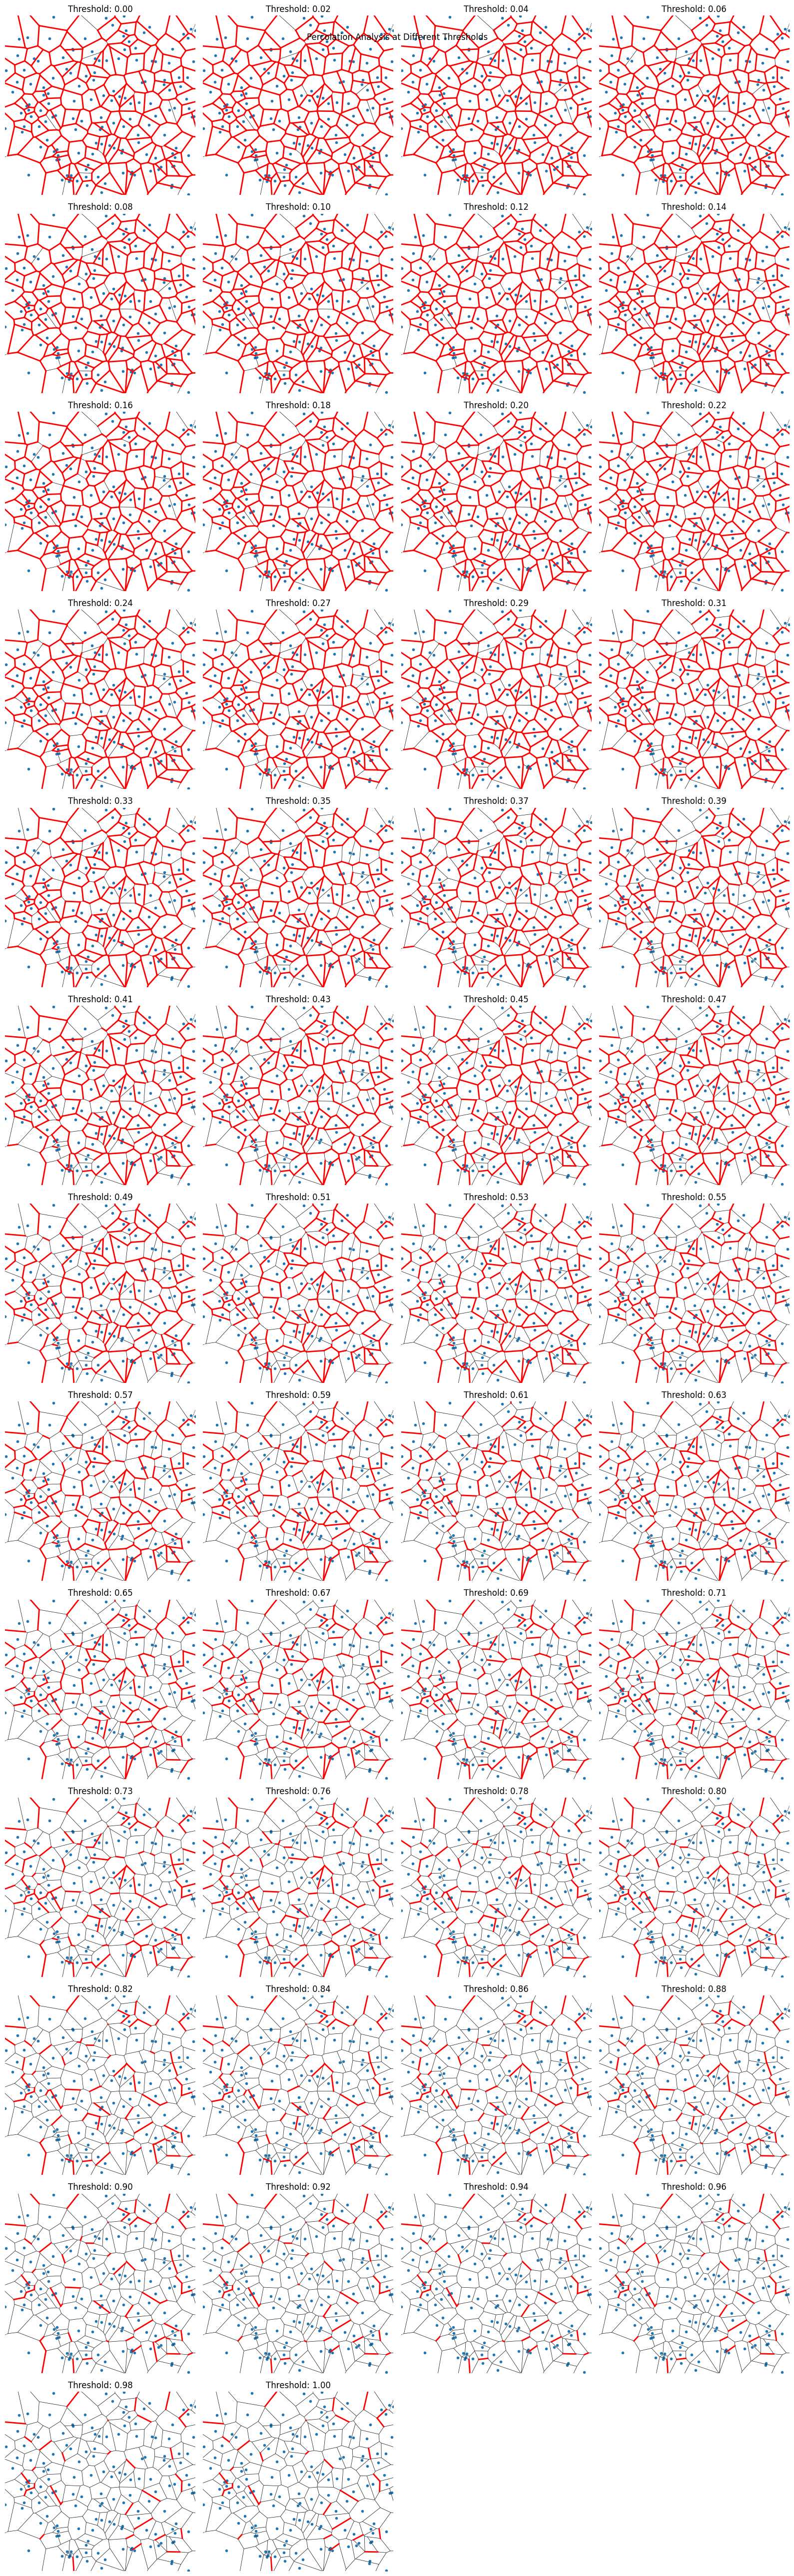

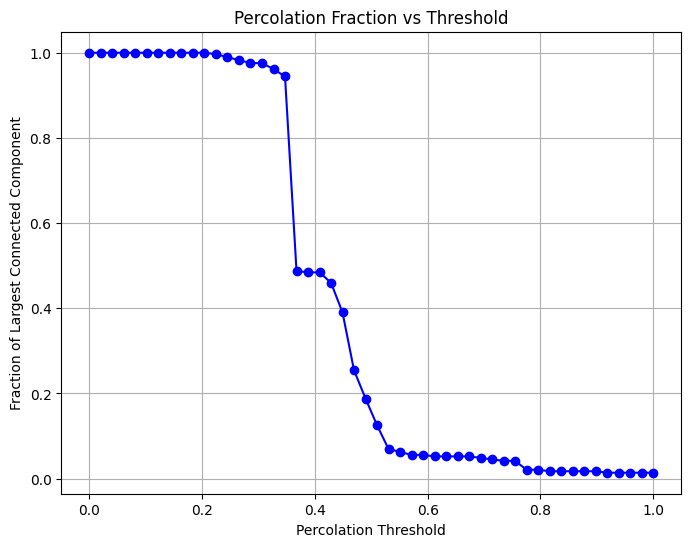

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.sparse.csgraph import connected_components

def generate_voronoi(num_points=100, xlim=(0, 1), ylim=(0, 1), mean=0.5, variance=0.1, N=10):
    """
    Generate and plot a Voronoi diagram to simulate a polycrystalline microstructure with bond percolation.
    Also, estimate the percolation threshold where continuous boundaries break.
    """
    points = np.random.rand(num_points, 2)
    vor = Voronoi(points)
    bond_values = np.random.normal(mean, np.sqrt(variance), len(vor.ridge_vertices))
    thresholds = np.linspace(0, 1, N)
    
    rows = int(np.ceil(N / 4))
    fig, axes = plt.subplots(rows, 4, figsize=(16, rows * 4))
    axes = axes.flatten()
    percolation_fractions = []
    
    for i, threshold in enumerate(thresholds):
        if i >= len(axes):
            break
        ax = axes[i]
        voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=0.5)
        
        adjacency_matrix = np.zeros((len(vor.vertices), len(vor.vertices)))
        
        for j, ridge in enumerate(vor.ridge_vertices):
            if -1 not in ridge and bond_values[j] >= threshold:
                point1, point2 = vor.vertices[ridge]
                ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'r', lw=2)
                adjacency_matrix[ridge[0], ridge[1]] = 1
                adjacency_matrix[ridge[1], ridge[0]] = 1
        
        num_components, labels = connected_components(csgraph=adjacency_matrix, directed=False)
        largest_component_size = max(np.bincount(labels)) / len(vor.vertices)
        percolation_fractions.append(largest_component_size)
        
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.set_title(f"Threshold: {threshold:.2f}")
    
    for i in range(len(thresholds), len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle("Percolation Analysis at Different Thresholds")
    plt.tight_layout()
    plt.show()
    
    # Plot percolation fraction vs threshold
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, percolation_fractions, marker='o', linestyle='-', color='b')
    plt.xlabel("Percolation Threshold")
    plt.ylabel("Fraction of Largest Connected Component")
    plt.title("Percolation Fraction vs Threshold")
    plt.grid(True)
    plt.show()
    
# Generate and analyze Voronoi microstructure percolation
generate_voronoi(num_points=150, mean=0.5, variance=0.1, N=50)